# Audio Tagging - 4th week ASET laboratory
## Exploratory data analysis & attempts of constructing different classification models

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install image

### Import dependencies

In [29]:
import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Embedding, Input, Dense, concatenate, Bidirectional, CuDNNGRU, CuDNNLSTM, ELU,
                          Dropout, LeakyReLU, BatchNormalization, SpatialDropout1D, Conv1D,
                          GlobalAveragePooling1D, GlobalMaxPooling1D)
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib.image as mpimg
from PIL import Image
import IPython.display as display

### Data Description 

**From Kaggle's data page for the competition**:

    The curated subset is a small set of manually-labeled data from FSD.

    Number of clips/class: 75 except in a few cases (where there are less)

    Total number of clips: 4970

    Avge number of labels/clip: 1.2

    Total duration: 10.5 hours
   
**The duration of the audio clips** ranges from $ 0.3 $ to $ 30s $ due to the diversity of the sound categories and the preferences of Freesound users when recording/uploading sounds. It can happen that a few of these audio clips present additional acoustic material beyond the provided ground truth label(s).

### Test Set:

The test set is used for system evaluation and consists of manually-labeled data from FSD. Since most of the train data come from YFCC, some acoustic domain mismatch between the train and test set can be expected. All the acoustic material present in the test set is labeled, except human error, considering the vocabulary of 80 classes used in the competition.

### Columns:

-  **fname**: the audio file name, eg, 0006ae4e.wav 
-  **labels**: the audio classification label(s) (ground truth). 

**Note that the number of labels per clip can be one, eg, Bark or more, eg, "Walk_and_footsteps,Slam".**

In [4]:
# Path specifications
KAGGLE_DIR = 'data/'
train_curated_path = KAGGLE_DIR + 'train_curated/'
test_path = KAGGLE_DIR + 'test/'

# Set seed for reproducability
seed = 1234
np.random.seed(seed)
tf.set_random_seed(seed)

# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
sample_submission.csv         | 0.58 MB
test                          | 0.66 MB
train_curated                 | 1.05 MB
train_curated.csv             | 0.14 MB
train_noisy                   | 3.41 MB
train_noisy.csv               | 0.58 MB


### Evaluation metric

The **task** consists of **predicting the audio labels (tags) for every test clip**. Some test clips bear one label while others bear several labels. The predictions are to be done at the clip level, i.e., no start/end timestamps for the sound events are required.

The primary competition metric will be **label-weighted label-ranking average precision (lwlrap, pronounced "Lol wrap")**. This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels).

**The formula for label-ranking average precision (LRAP)** is as follows:
$ LRAP(y, \widehat{f}) = \frac{1}{n_{samples}} \sum\limits_{i=0}^{n_{samples}-1}\frac{1}{\left\lVert y_i\right\rVert_0}\sum\limits_{j:y_{ij} = 1} \frac{\mathcal{L}_{ij}}{rank_{ij}}$

In [5]:
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

### Helper Functions and Preprocessing 

In [6]:
n_classes = 80

In [7]:
def split_and_label(rows_labels, n_classes):
    '''
    Retrieves a list of all the relevant classes. This is necessary due to 
    the multi-labeling of the initial csv file.
    '''
    row_labels_list = []
    for row in rows_labels:
        row_labels = row.split(',')
        labels_array = np.zeros((n_classes))
        for label in row_labels:
            index = label_mapping[label]
            labels_array[index] = 1
        row_labels_list.append(labels_array)
    return row_labels_list

In [8]:
# Load in data
df = pd.read_csv(KAGGLE_DIR + 'train_curated.csv')
train_noisy = pd.read_csv(KAGGLE_DIR + 'train_noisy.csv')
test_df = pd.read_csv(KAGGLE_DIR + 'sample_submission.csv')

# Retrieve labels
label_columns = test_df.columns[1:]
label_mapping = dict((label, index) for index, label in enumerate(label_columns))
for col in label_columns:
    df[col] = 0  
df[label_columns] = split_and_label(df['labels'], n_classes)
df['num_labels'] = df[label_columns].sum(axis=1)

In [9]:
# Check dataframes
print('Training dataframe:')
display(df.head(3))

print('Testing dataframe:')
test_df.head(3)

Training dataframe:


,fname,labels,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),...,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),num_labels
0,0006ae4e.wav,Bark,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0019ef41.wav,Raindrop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,001ec0ad.wav,Finger_snapping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Testing dataframe:


,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,426eb1e0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,428d70bb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
print(df.shape, test_df.shape)

(4970, 83) (3361, 81)


In [11]:
label_columns = test_df.columns[1:]

In [12]:
label_mapping = dict((label, index) for index, label in enumerate(label_columns))

In [13]:
label_mapping

{'Accelerating_and_revving_and_vroom': 0,
 'Accordion': 1,
 'Acoustic_guitar': 2,
 'Applause': 3,
 'Bark': 4,
 'Bass_drum': 5,
 'Bass_guitar': 6,
 'Bathtub_(filling_or_washing)': 7,
 'Bicycle_bell': 8,
 'Burping_and_eructation': 9,
 'Bus': 10,
 'Buzz': 11,
 'Car_passing_by': 12,
 'Cheering': 13,
 'Chewing_and_mastication': 14,
 'Child_speech_and_kid_speaking': 15,
 'Chink_and_clink': 16,
 'Chirp_and_tweet': 17,
 'Church_bell': 18,
 'Clapping': 19,
 'Computer_keyboard': 20,
 'Crackle': 21,
 'Cricket': 22,
 'Crowd': 23,
 'Cupboard_open_or_close': 24,
 'Cutlery_and_silverware': 25,
 'Dishes_and_pots_and_pans': 26,
 'Drawer_open_or_close': 27,
 'Drip': 28,
 'Electric_guitar': 29,
 'Fart': 30,
 'Female_singing': 31,
 'Female_speech_and_woman_speaking': 32,
 'Fill_(with_liquid)': 33,
 'Finger_snapping': 34,
 'Frying_(food)': 35,
 'Gasp': 36,
 'Glockenspiel': 37,
 'Gong': 38,
 'Gurgling': 39,
 'Harmonica': 40,
 'Hi-hat': 41,
 'Hiss': 42,
 'Keys_jangling': 43,
 'Knock': 44,
 'Male_singing': 45

In [14]:
for col in tqdm(label_columns):
    df[col] = 0
    train_noisy[col] = 0
    
print(df.shape, train_noisy.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 363.73it/s]


(4970, 83) (19815, 82)


In [15]:
train_curated_labels = split_and_label(df['labels'], n_classes)
train_noisy_labels = split_and_label(train_noisy['labels'], n_classes)

In [16]:
df[label_columns] = train_curated_labels
train_noisy[label_columns] = train_noisy_labels

In [17]:
df['num_labels'] = df[label_columns].sum(axis=1)
train_noisy['num_labels'] = train_noisy[label_columns].sum(axis=1)

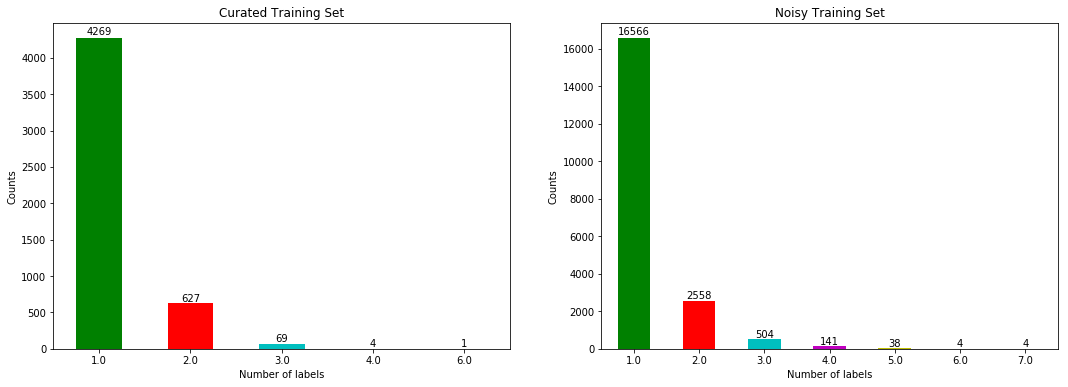

In [18]:
plt.figure(figsize=(18,6))

plt.subplot(121)
ax1 = df['num_labels'].value_counts().plot(kind='bar',  colors=['g','r','c','m','y','k','w','b'])
plt.xlabel('Number of labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.title('Curated Training Set')

norm = matplotlib.colors.Normalize(vmin=0, vmax=20)

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height() * 1.005), 
                ha='center',
                va='center',
                xytext=(0,5), 
                textcoords='offset points')

plt.subplot(122)
ax2 = train_noisy['num_labels'].value_counts().sort_index().plot(kind='bar', colors=['g','r','c','m','y','k','w','b'])
plt.xlabel('Number of labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.title('Noisy Training Set')

index = 30
for p in ax2.patches:
    index +=1
    ax2.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height() * 1.005), 
                ha='center',
                va='center',
                xytext=(0,5), 
                textcoords='offset points')
plt.show()

### Preprocess data

In [19]:
# Preprocessing parameters
sr = 44100 # Sampling rate
duration = 5
hop_length = 347 # to make time steps 128
fmin = 20
fmax = sr // 2
n_mels = 128
n_fft = n_mels * 20
samples = sr * duration

In [20]:
def read_audio(path):
    '''
    Reads in the audio file and returns
    an array that we can turn into a melspectogram
    '''
    y, _ = librosa.core.load(path, sr=44100)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

In [21]:
def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sr,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    return librosa.power_to_db(spectrogram).astype(np.float32)

In [22]:
def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    mels = audio_to_melspectrogram(read_audio(path))
    return mels


In [23]:
def convert_wav_to_image(df, path):
    X = []
    for _,row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram('{}/{}'.format(path[0],
                                                  str(row['fname'])))
        X.append(x.transpose())
    return X

In [24]:
def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

In [25]:
def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

In [26]:
# Preprocess dataset and create validation sets
X = np.array(convert_wav_to_image(df, [train_curated_path]))
X = normalize_dataset(X)
Y = df[label_columns].values
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=seed)

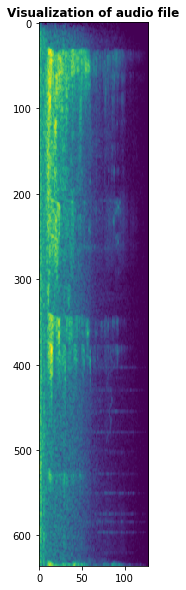

In [27]:
# Visualize an melspectogram example
plt.figure(figsize=(15,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(X[0]);

### Gated Recurrent Neural Networks

**GRU (Gated Recurrent Unit)** aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.

To solve the vanishing gradient problem of a standard RNN, GRU uses, so called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

To explain the mathematics behind that process we will examine a single unit from the following recurrent neural network:

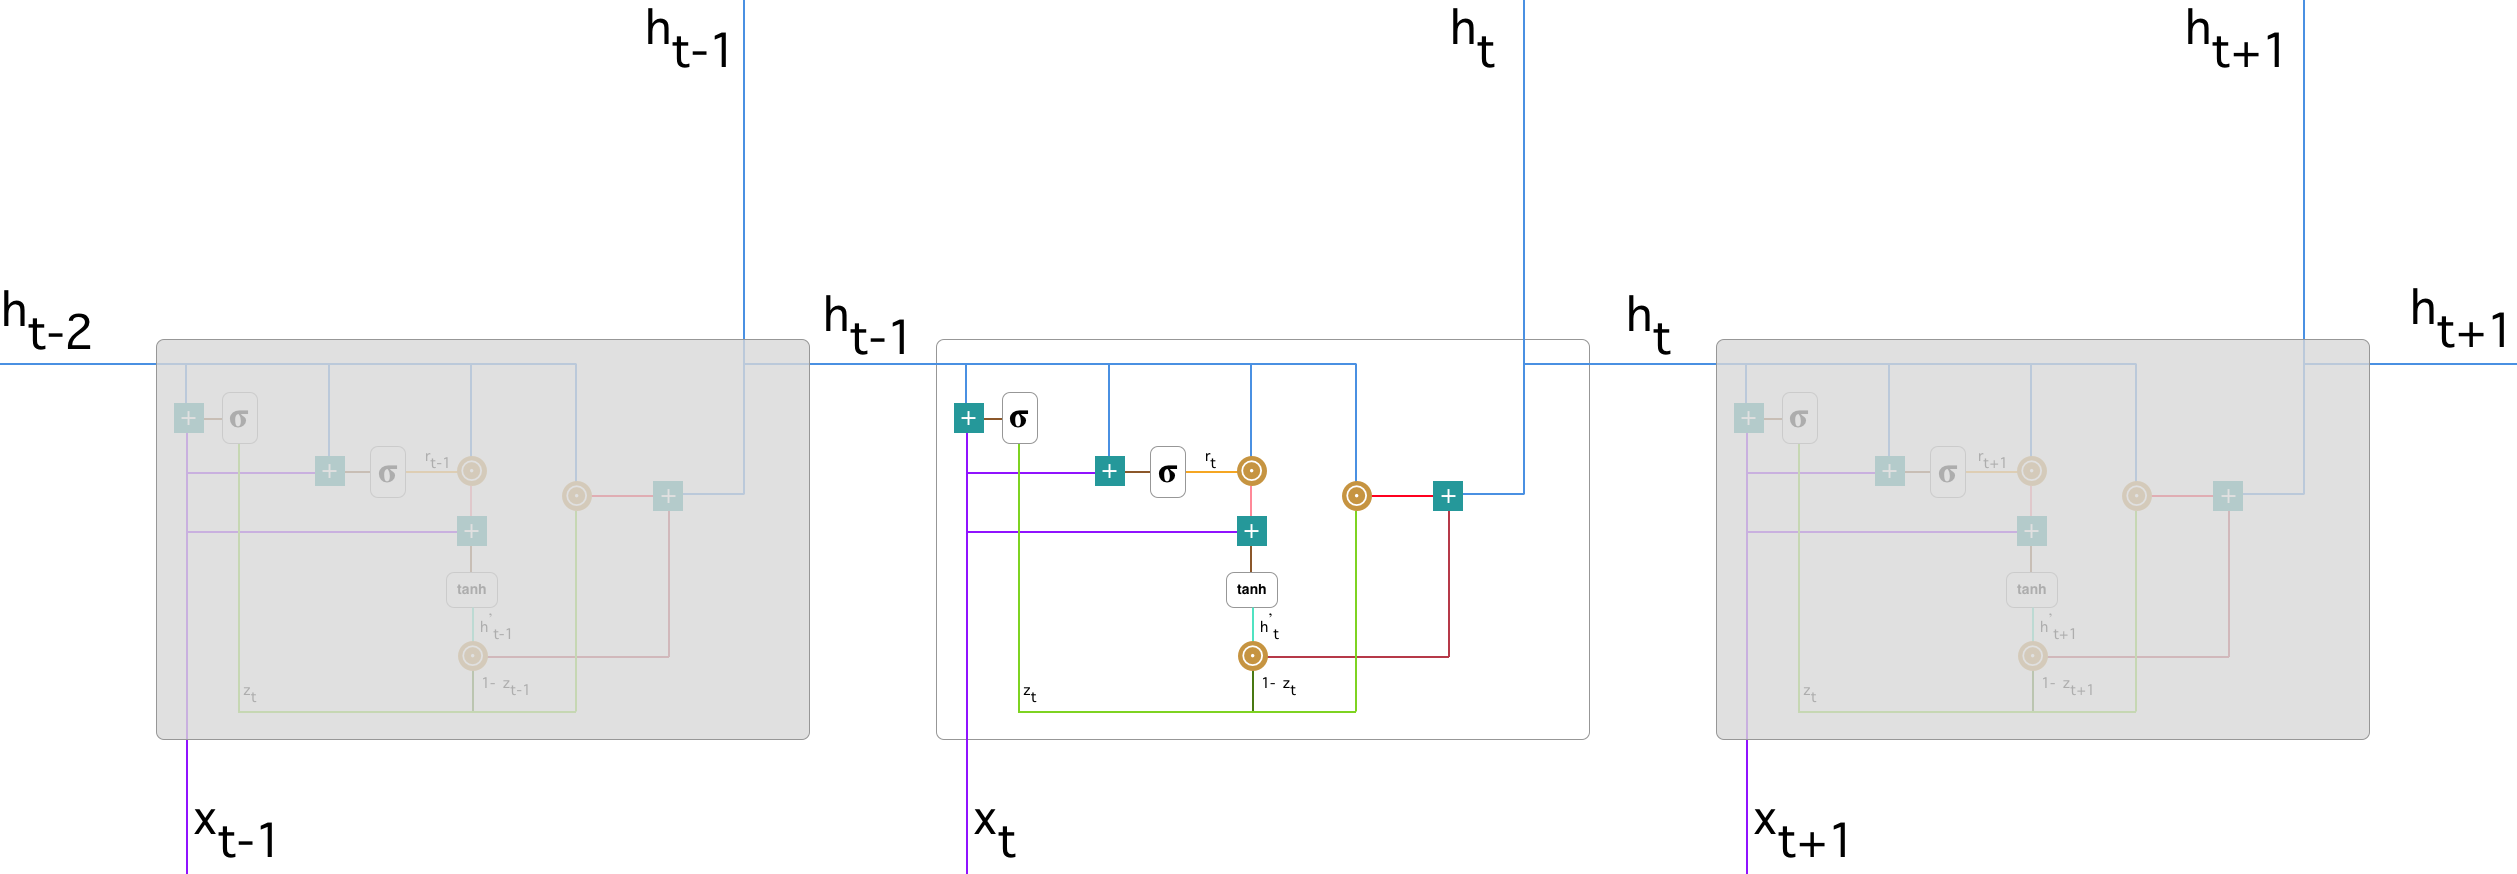

In [30]:
display.display(Image.open('gru/overall_gru.png'))

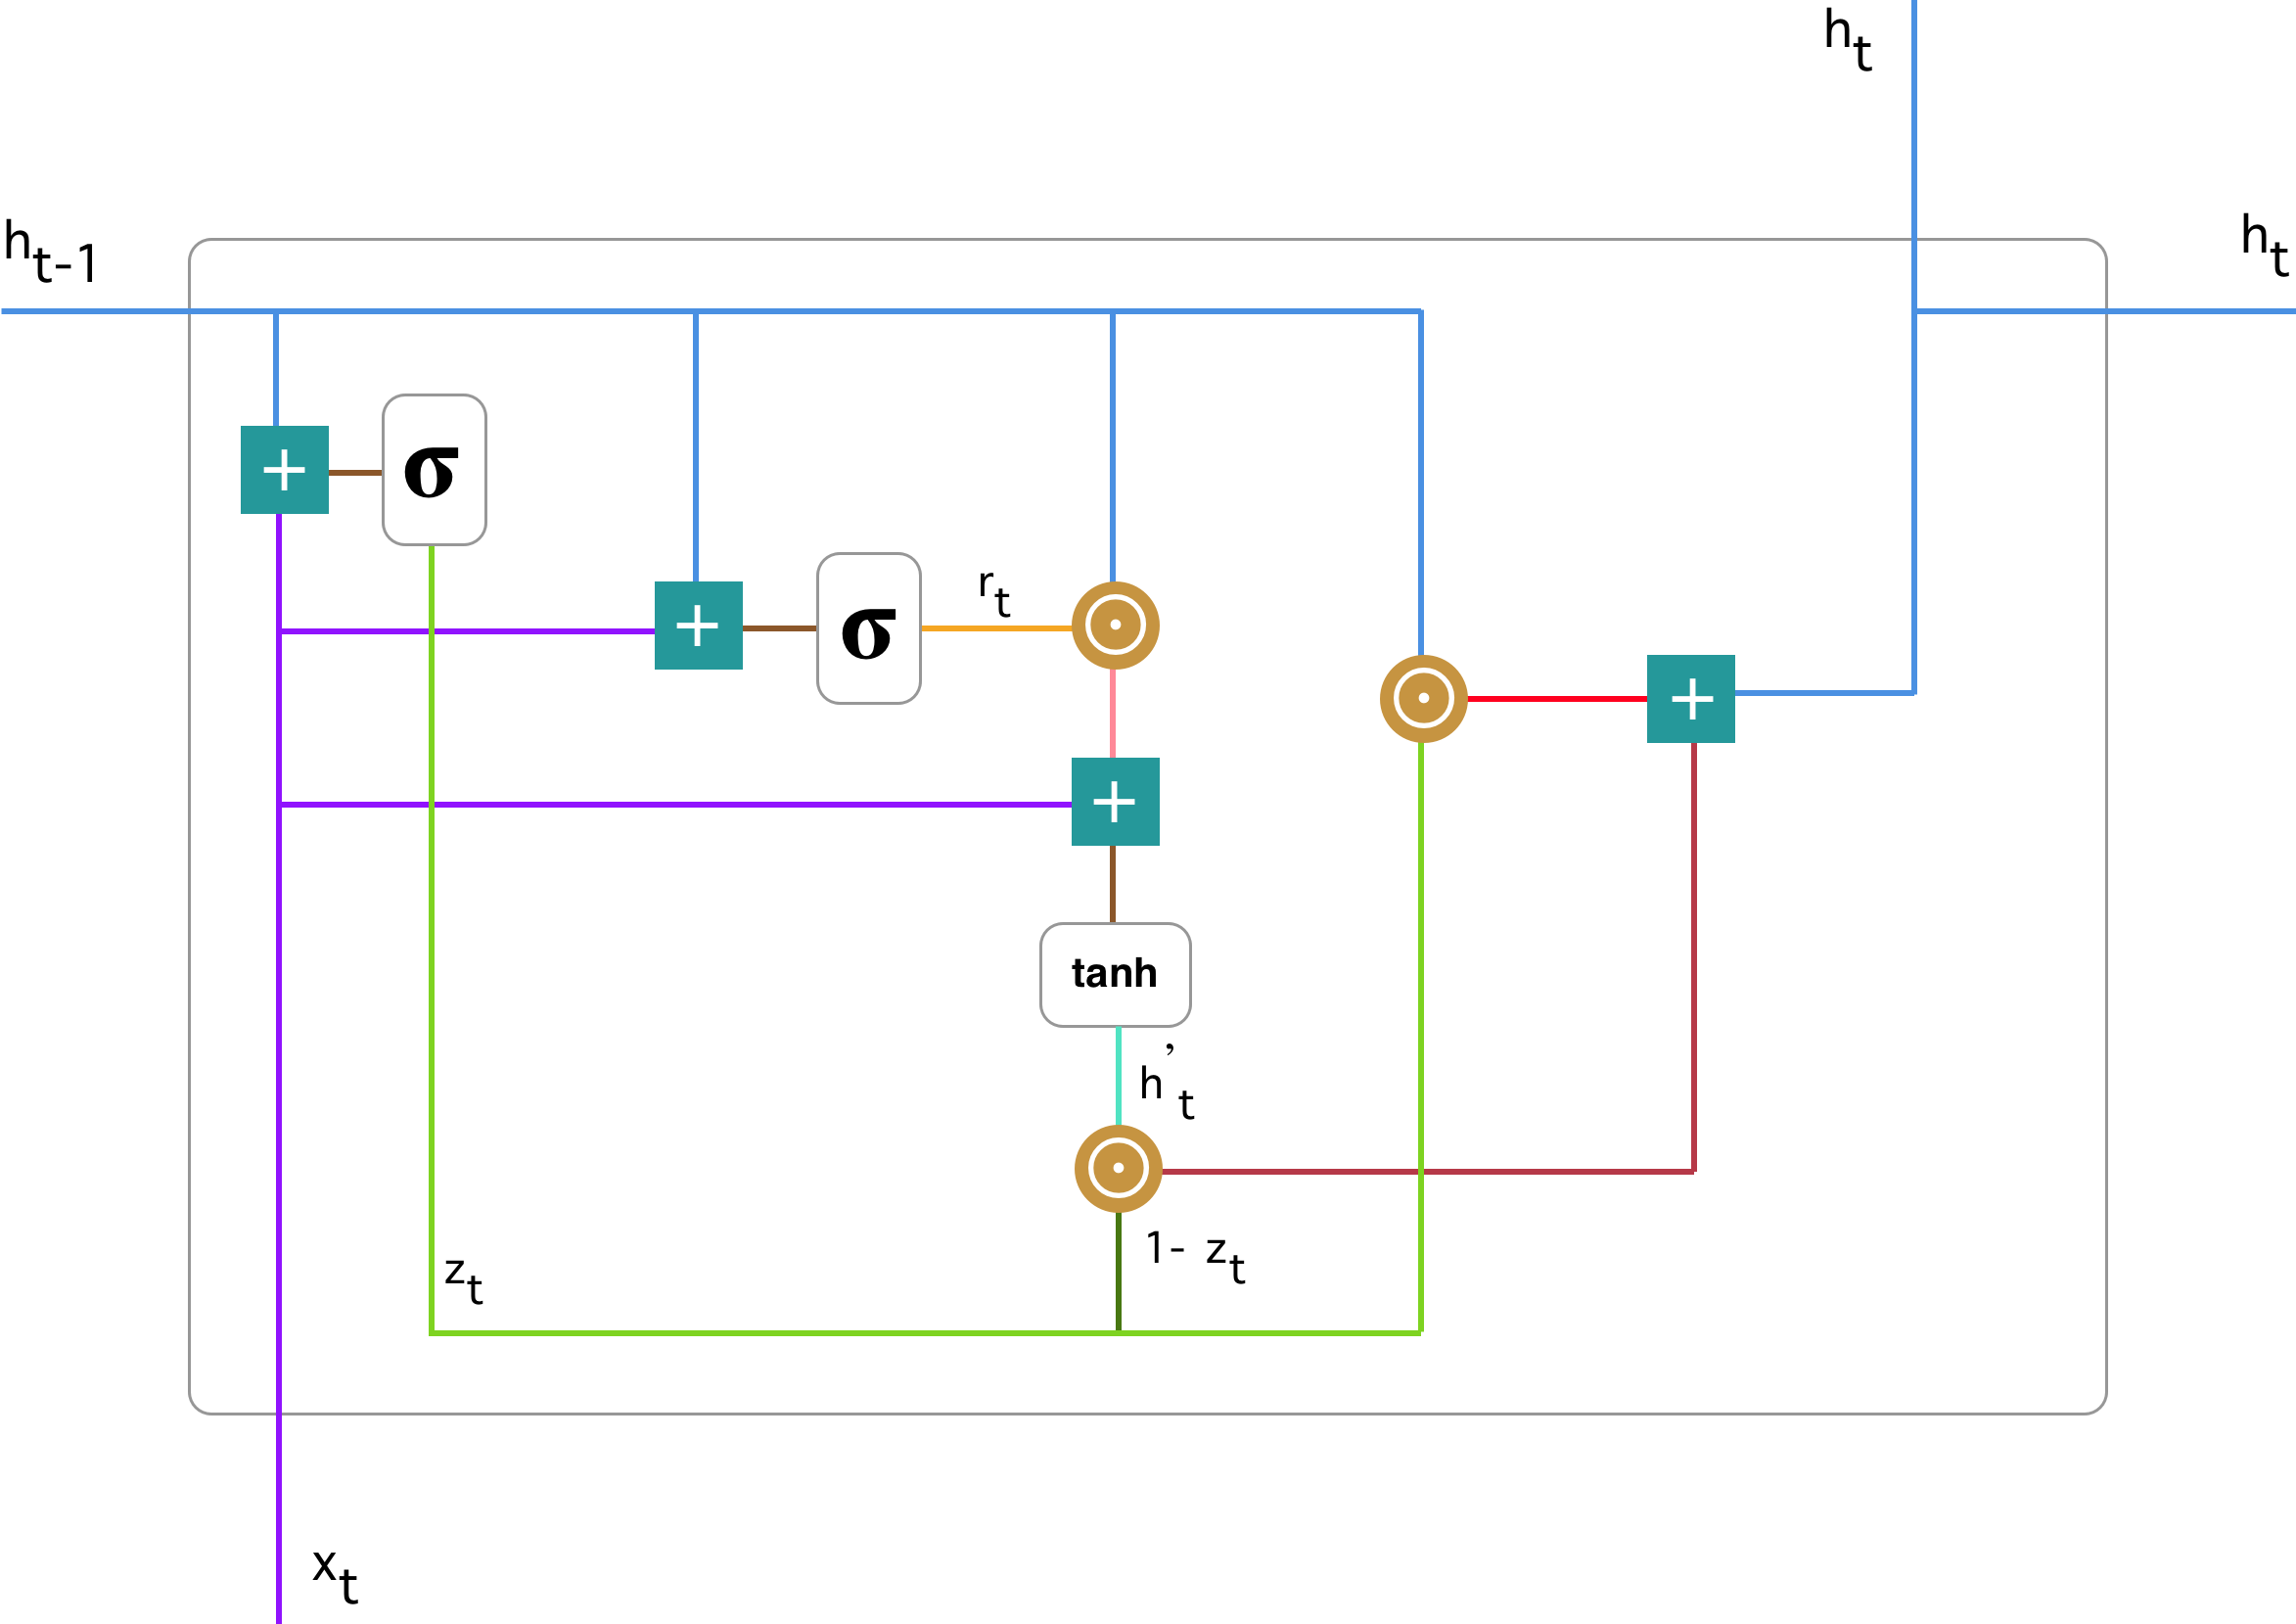

In [31]:
display.display(Image.open('gru/zoom_gru.png'))

In [32]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [33]:
sequence_input = Input(shape=(636,128), dtype='float32')
x = CuDNNGRU(128, return_sequences=True)(sequence_input) 
att = Attention(636)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x) 

x = concatenate([att, avg_pool, max_pool])

preds = Dense(80, activation='softmax')(x)

model = Model(sequence_input, preds)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 636, 128)     0                                            
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 636, 128)     99072       input_1[0][0]                    
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 128)          764         cu_dnngru_1[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 128)          0           cu_dnngru_1[0][0]                
_____________________________________

In [34]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.005),metrics=['acc'])

In [35]:
assert len(x_train) == len(y_train)
assert len(x_val) == len(y_val)

In [36]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=3)

In [39]:
model.fit(np.array(x_train),
          y_train,
          batch_size=1024,
          epochs=100,
          validation_data=(np.array(x_val), y_val),
          callbacks = [es])

In [ ]:
y_train_pred = model.predict(np.array(x_train))
y_val_pred = model.predict(np.array(x_val))

In [ ]:
train_lwlrap = calculate_overall_lwlrap_sklearn(y_train, y_train_pred)
val_lwlrap = calculate_overall_lwlrap_sklearn(y_val, y_val_pred)

print(f'Training LWLRAP : {train_lwlrap:.4f}')
print(f'Validation LWLRAP : {val_lwlrap:.4f}')

In [ ]:
%%time
X_test = np.array(convert_wav_to_image(test, source=[test_path]))
predictions = model.predict(np.array(X_test))
test[label_columns] = predictions
test.to_csv('submission.csv', index=False)

### References

1. https://www.kaggle.com/chewzy/gru-w-attention-baseline-model-curated
2. https://www.kaggle.com/carlolepelaars/bidirectional-lstm-for-audio-labeling-with-keras